In [3]:
from langchain_core.tools import tool
import httpx
import os
from dotenv import load_dotenv

load_dotenv()

True

In [76]:


API_KEY = ''

@tool
def is_valid_stock_symbol(symbol: str) -> bool:
    """
    Checks the stock symbol is valid or not
    Args:
        symbol: The stock symbol to validate.
    Returns:
        True if the symbol is valid, False otherwise.
    """
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "SYMBOL_SEARCH",
        "keywords": symbol,
        "apikey": API_KEY
    }

    try:
        response = httpx.get(url, params=params, timeout=5)
        response.raise_for_status()
        data = response.json()

        # Check if the API returned matches for the given symbol
        if "bestMatches" in data and any(match["1. symbol"] == symbol for match in data["bestMatches"]):
            return True
        
    except httpx.HTTPStatusError:
        print("Error: Invalid response from API.")
    except httpx.RequestError:
        print("Error: Unable to connect to API.")

    return False


In [77]:
import httpx

@tool
def get_stock_price(symbol: str) -> float:
    """
    Fetches the current stock price for a given symbol using Alpha Vantage.
    Args:
        symbol: The stock symbol to fetch the price for.
    Returns:
        The latest stock price as a float, or raises an exception.
    """
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "GLOBAL_QUOTE",
        "symbol": symbol,
        "apikey": API_KEY
    }

 
    response = httpx.get(url, params=params, timeout=5)
    response.raise_for_status()
    data = response.json()

    print(data)

    # Extract stock price
    if "Global Quote" in data and "05. price" in data["Global Quote"]:
        return float(data["Global Quote"]["05. price"])
        
    

# Example usage
print(get_stock_price("AAPL"))  # Fetches Apple's stock price


{'Error Message': 'the parameter apikey is invalid or missing. Please claim your free API key on (https://www.alphavantage.co/support/#api-key). It should take less than 20 seconds.'}
None


In [18]:
from langchain_ollama import ChatOllama

tools = [get_stock_price]
llm = ChatOllama(model="qwen2", base_url="http://localhost:11434")
llm_with_tools = llm.bind_tools(tools)

In [37]:
from langgraph.graph.message import MessageGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage

system_message = SystemMessage(content=(
        "You are a stock market assistant that provides real-time stock prices, "
        "market trends, and basic financial data. Respond concisely with accurate "
        "information about stock prices. If a stock symbol is invalid, inform the user."
        "your answer should be short"
    ))

builder = MessageGraph()

builder.add_node("ai", lambda state: llm_with_tools.invoke([system_message] + state))
builder.add_node("tools", ToolNode(tools))

builder.set_entry_point("ai")
builder.add_conditional_edges('ai', tools_condition)
builder.add_edge('tools', 'ai')

memory = MemorySaver()
compiled_graph = builder.compile(checkpointer=memory)

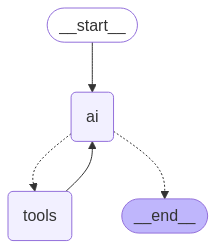

In [38]:
from IPython.display import Image

display(Image(compiled_graph.get_graph(xray=True).draw_mermaid_png()))

In [67]:
from time import strftime
thread_id = strftime(f"stock-1-{strftime('%Y-%m-%d')}")

In [69]:
from langchain_core.runnables import RunnableConfig

config: RunnableConfig = {"configurable": {"thread_id": thread_id}}

In [70]:
from langchain_core.messages import HumanMessage
my_message = [HumanMessage(content="What is stock price of IBM?")]

compiled_graph.invoke(my_message, config=config)

[HumanMessage(content='What is stock price of IBM?', additional_kwargs={}, response_metadata={}, id='e2dafb1d-a808-4197-a9ec-6c6e1754f7f2'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2', 'created_at': '2025-03-08T14:48:39.648761Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2686234700, 'load_duration': 67946100, 'prompt_eval_count': 231, 'prompt_eval_duration': 340000000, 'eval_count': 26, 'eval_duration': 2271000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-17c1b4d8-ed98-4e6c-8adc-889d36b99e7a-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'IBM'}, 'id': 'ab77c965-3696-4c07-9214-bce66a51fa54', 'type': 'tool_call'}], usage_metadata={'input_tokens': 231, 'output_tokens': 26, 'total_tokens': 257}),
 ToolMessage(content="Error: Exception('Error: Unable to fetch stock price')\n Please fix your mistakes.", name='get_stock_price', id='ef2eafe3-e9b6-48ac-83b2-6708b0e68050', tool_call

In [44]:
state = compiled_graph.get_state(config=config)
state

StateSnapshot(values=[HumanMessage(content='What is stock price of IBM?', additional_kwargs={}, response_metadata={}, id='d453c55c-8f4e-4710-84db-788150c58b08'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2', 'created_at': '2025-03-08T13:56:25.4271337Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12527776500, 'load_duration': 7259718600, 'prompt_eval_count': 231, 'prompt_eval_duration': 1327000000, 'eval_count': 26, 'eval_duration': 2969000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-8fe96623-a572-4a8d-aa0e-ae4f6b44f9de-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'IBM'}, 'id': '17c1750e-2747-4e46-ae95-cb5ae2295644', 'type': 'tool_call'}], usage_metadata={'input_tokens': 231, 'output_tokens': 26, 'total_tokens': 257}), ToolMessage(content='261.54', name='get_stock_price', id='c0b37da0-9079-48f3-9f4f-7bba949ad5c3', tool_call_id='17c1750e-2747-4e46-ae95-cb5ae2295644'), AI

In [48]:
history = list(compiled_graph.get_state_history(config=config))
history

[StateSnapshot(values=[HumanMessage(content='What is stock price of IBM?', additional_kwargs={}, response_metadata={}, id='d453c55c-8f4e-4710-84db-788150c58b08'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2', 'created_at': '2025-03-08T13:56:25.4271337Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12527776500, 'load_duration': 7259718600, 'prompt_eval_count': 231, 'prompt_eval_duration': 1327000000, 'eval_count': 26, 'eval_duration': 2969000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-8fe96623-a572-4a8d-aa0e-ae4f6b44f9de-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'IBM'}, 'id': '17c1750e-2747-4e46-ae95-cb5ae2295644', 'type': 'tool_call'}], usage_metadata={'input_tokens': 231, 'output_tokens': 26, 'total_tokens': 257}), ToolMessage(content='261.54', name='get_stock_price', id='c0b37da0-9079-48f3-9f4f-7bba949ad5c3', tool_call_id='17c1750e-2747-4e46-ae95-cb5ae2295644'), A

#Replaying

In [50]:
to_replay = history[-2]
to_replay

StateSnapshot(values=[HumanMessage(content='What is stock price of IBM?', additional_kwargs={}, response_metadata={}, id='d453c55c-8f4e-4710-84db-788150c58b08')], next=('ai',), config={'configurable': {'thread_id': 'stock-2025-03-08', 'checkpoint_ns': '', 'checkpoint_id': '1effc251-7676-6aaf-8000-94977013e14d'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': 'stock-2025-03-08', 'step': 0, 'parents': {}}, created_at='2025-03-08T13:56:10.841757+00:00', parent_config={'configurable': {'thread_id': 'stock-2025-03-08', 'checkpoint_ns': '', 'checkpoint_id': '1effc251-766d-6e24-bfff-5e1421c47754'}}, tasks=(PregelTask(id='78b997ec-ca6e-2d14-d113-82c5567a150a', name='ai', path=('__pregel_pull', 'ai'), error=None, interrupts=(), state=None, result=AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2', 'created_at': '2025-03-08T13:56:25.4271337Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12527776500, 'load_duration': 7259718600, 'prompt_eval_coun

In [51]:
len(history)

5

In [54]:
compiled_graph.invoke(None, config=to_replay.config)

[HumanMessage(content='What is stock price of IBM?', additional_kwargs={}, response_metadata={}, id='d453c55c-8f4e-4710-84db-788150c58b08'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2', 'created_at': '2025-03-08T14:06:58.0624576Z', 'done': True, 'done_reason': 'stop', 'total_duration': 11058452300, 'load_duration': 6772190600, 'prompt_eval_count': 231, 'prompt_eval_duration': 1038000000, 'eval_count': 26, 'eval_duration': 2494000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-716cdd31-6ee8-4877-9d13-a4140c630bd5-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'IBM'}, 'id': 'de0c9781-37cc-41b9-ab69-fec7cd53c42d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 231, 'output_tokens': 26, 'total_tokens': 257}),
 ToolMessage(content='261.54', name='get_stock_price', id='25e35dce-57c2-406e-b892-7a2999d261c5', tool_call_id='de0c9781-37cc-41b9-ab69-fec7cd53c42d'),
 AIMessage(content='The cu

In [57]:
history = list(compiled_graph.get_state_history(config=config))
history



[StateSnapshot(values=[HumanMessage(content='What is stock price of IBM?', additional_kwargs={}, response_metadata={}, id='d453c55c-8f4e-4710-84db-788150c58b08'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2', 'created_at': '2025-03-08T14:06:58.0624576Z', 'done': True, 'done_reason': 'stop', 'total_duration': 11058452300, 'load_duration': 6772190600, 'prompt_eval_count': 231, 'prompt_eval_duration': 1038000000, 'eval_count': 26, 'eval_duration': 2494000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-716cdd31-6ee8-4877-9d13-a4140c630bd5-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'IBM'}, 'id': 'de0c9781-37cc-41b9-ab69-fec7cd53c42d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 231, 'output_tokens': 26, 'total_tokens': 257}), ToolMessage(content='261.54', name='get_stock_price', id='25e35dce-57c2-406e-b892-7a2999d261c5', tool_call_id='de0c9781-37cc-41b9-ab69-fec7cd53c42d'), A

In [59]:
len(history)


8

In [61]:
to_forking = history[-2]
to_forking


StateSnapshot(values=[HumanMessage(content='What is stock price of IBM?', additional_kwargs={}, response_metadata={}, id='d453c55c-8f4e-4710-84db-788150c58b08')], next=('ai',), config={'configurable': {'thread_id': 'stock-2025-03-08', 'checkpoint_ns': '', 'checkpoint_id': '1effc251-7676-6aaf-8000-94977013e14d'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': 'stock-2025-03-08', 'step': 0, 'parents': {}}, created_at='2025-03-08T13:56:10.841757+00:00', parent_config={'configurable': {'thread_id': 'stock-2025-03-08', 'checkpoint_ns': '', 'checkpoint_id': '1effc251-766d-6e24-bfff-5e1421c47754'}}, tasks=(PregelTask(id='78b997ec-ca6e-2d14-d113-82c5567a150a', name='ai', path=('__pregel_pull', 'ai'), error=None, interrupts=(), state=None, result=AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2', 'created_at': '2025-03-08T13:56:25.4271337Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12527776500, 'load_duration': 7259718600, 'prompt_eval_coun

In [66]:
compiled_graph.update_state(to_forking.config, [HumanMessage(content="What is stock price of NVDA?", id=to_forking.values[-1].id)])

{'configurable': {'thread_id': 'stock-2025-03-08',
  'checkpoint_ns': '',
  'checkpoint_id': '1effc2c3-dab5-6743-8001-43099205346c'}}